In [195]:
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt

In [196]:
def jacobian(f, x, u, eps=1e-6):
    """a function to linearise f
    f: a vector function, xdot = f(x, u)
    x: state
    u: inputs
    """
    Ja = np.zeros((len(x), len(x)))

    for i in range(len(x)):
        x1 = x.copy()
        x2 = x.copy()
        
        x1[i] += eps
        x2[i] -= eps

        f1 = f(x1, u)
        f2 = f(x2, u)

        Ja[:, i] = (f1 - f2) / (2 * eps)

    Jb = np.zeros((len(x), len(u)))
    for i in range(len(u)):
        u1 = u.copy()
        u2 = u.copy()

        u1[i] += eps
        u2[i] -= eps

        f1 = f(x, u1)
        f2 = f(x, u2)

        Jb[:, i] = (f1 - f2) / (2 * eps)   

    return Ja, Jb

def bicycle_ode(x, u):
    """calculates -> xdot = f(x,u)"""
    # constants
    M = 1 # mass of the car [kg]
    Lf = 0.5
    Lr = 0.5
    L = Lf + Lr
    Iz = (2 / 5) * M * (0.5 * L) ** 2
    Cf = 1
    Cr = 1

    _, _, vlat, vlon, psi, omega = x
    delta, f = u

    cos_psi = 1 - (psi ** 2) / 2# np.cos(psi)
    sin_psi = psi # np.sin(psi)
    a1 = - ((Cr + Cf)/(M * vlon))
    a2 = ((Cr*Lr - Cf*Lf)/(M*vlon) - vlon)
    a3 = ((Lr*Cr - Lf*Cf)/(Iz * vlon))
    a4 = - ((Lf**2 * Cf + Lr ** 2 * Cr)/(Iz * vlon))
    
    x1dot       = vlon * cos_psi - vlat * sin_psi
    y1dot       = vlon * sin_psi + vlat * cos_psi
    vlatdot     = a1*vlat + a2*omega + (Cf/M)*delta
    vlondot     = f / M
    psidot      = omega
    omegadot    = a3 * vlat + a4 * omega + ((Cf * Lf) / Iz) * delta

    xdot = np.array([x1dot, y1dot, vlatdot, vlondot, psidot, omegadot])
    
    return xdot

class DynamicModel:
    def __init__(self, ode, dt):
        """ode[func]: a vector function calculating => xdot = f(x, u)
        dt[float]: a timestep
        """
        self._ode = ode
        self._dt = dt
        self._A = None
        self._B = None

        # limits
        self.x_ulim = np.array([200., 200., 1., 10., 0.4, 1.])
        self.x_llim = np.array([-200., -200., -1., -10., -0.4, 1.])

        self.u_ulim = np.array([0.8, 4.])
        self.u_llim = np.array([-0.8, -4])


    def get_system(self, x, u):
        """return the linearised A and B matrices of the system"""
        Ja, Jb = jacobian(self._ode, x, u)
        A = np.eye(len(x)) + Ja * self._dt
        B = Jb * self._dt

        self._A = A
        self._B = B
    
    def next_x(self, x, u):
        # x_new = self._A @ x + self._B @ u #.reshape((len(u), 1))
        x_new = x + self._ode(x, u) * self._dt
        return x_new
    

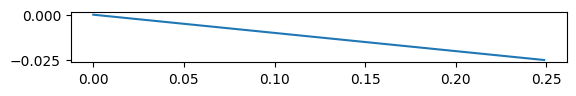

In [197]:
def dummy_controller(x, x_goal):
    return np.array([0, 1])

# Problem parameters
dt = 0.25                                     # Sampling period
T = 1                                        # steps to simulate
x = np.array([0, 0, 0., 1, -0.1, 0.])                # Initial state
x_target =  np.array([150., 0., 0., 0., 0., 0.])              # Dummy for this exercise

x_history = []
u_history = []

bicycle_model = DynamicModel(bicycle_ode, dt)
bicycle_model.get_system(x, np.array([0, 0]))

for t in np.linspace(0, dt*T, T + 1):
    u = dummy_controller(x, x_target)
    
    x_new = bicycle_model.next_x(x, u)
    # print(x_new)

    x_history.append(x)
    u_history.append(u)

    x = x_new

x_history = np.array(x_history)
u_history = np.array(u_history)

fig, ax = plt.subplots()
ax.plot(x_history[:, 0], x_history[:, 1])
ax.set(aspect="equal")
plt.show()

In [198]:
def mpc_control(model, N, x_init, x_target, dt):
    """a simple convex MPC controller
    N: MPC horizon
    """

    # DO NOT CHANGE THESE PARAMETERS #
    weight_input = 0.02*np.eye(2)    # Weight on the input
    weight_tracking = 1.0*np.eye(6) # Weight on the tracking state
    cost = 0.

    x_ulim = np.array([200., 200., 1., 10., 0.4, 1.])
    x_llim = np.array([-200., -200., -1., -10., -0.4, 1.])

    u_ulim = np.array([0.8, 1.])
    u_llim = np.array([-0.8, -1])

    constraints = []
    
    # Create the optimization variables
    x = cp.Variable((6, N + 1)) # cp.Variable((dim_1, dim_2))
    u = cp.Variable((2, N))
    # HINTS: 
    # ------------------------------1, 
    # - To add a constraint use
    #   constraints += [<constraint>] 
    #   i.e., to specify x <= 0, we would use 'constraints += [x <= 0]'
    # - To add to the cost, you can simply use
    #   'cost += <value>'
    # - Use @ to multiply matrices and vectors (i.e., 'A@x' if A is a matrix and x is a vector)
    # - A useful function to know is cp.quad_form(x, M) which implements x^T M x (do not use it for scalar x!)
    # - Use x[:, k] to retrieve x_k
  
    # For each stage in k = 0, ..., N-1
    constraints += [x[:, 0] == x_init]
    # constraints += [u[:, 0] == np.array([0, 0])]
    for k in range(N):
        # Add cost terms
        cost += cp.quad_form(x[:, k] - x_target, weight_tracking)  # Tracking cost
        cost += cp.quad_form(u[:, k], weight_input)  # Input cost

        # system dynamic constraints
        constraints += [x[:, k + 1] == model._A @ x[:, k] + model._B @ u[:, k]]

        # input and state constraints
        constraints += [u[:, k] >= u_llim, u[:, k] <= u_ulim]  # Input constraint
        constraints += [x[4, k] >= -0.4, x[4, k] <= 0.4]  # State constraint

        
    # EXERCISE: Implement the cost components and/or constraints that need to be added once, here
    
    # YOUR CODE HERE
    cost += cp.quad_form(x[:, N] - x_target, weight_tracking)

    # Solves the problem
    problem = cp.Problem(cp.Minimize(cost), constraints)
    problem.solve(solver=cp.OSQP)


    # We return the MPC input and the next state (and also the plan for visualization)
    return u[:, 0].value, x[:, 1].value, x[:, :].value, None



[array([-0., -0.]), array([-0., -0.]), array([-0., -0.]), array([-0., -0.]), array([-0., -0.]), array([-0., -0.]), array([-0., -0.]), array([-0., -0.]), array([-0., -0.]), array([-0., -0.]), array([-0., -0.]), array([-0., -0.]), array([-0., -0.]), array([-0., -0.]), array([-0., -0.]), array([-0., -0.]), array([-0., -0.]), array([-0., -0.]), array([-0., -0.]), array([-0., -0.]), array([-0., -0.])]


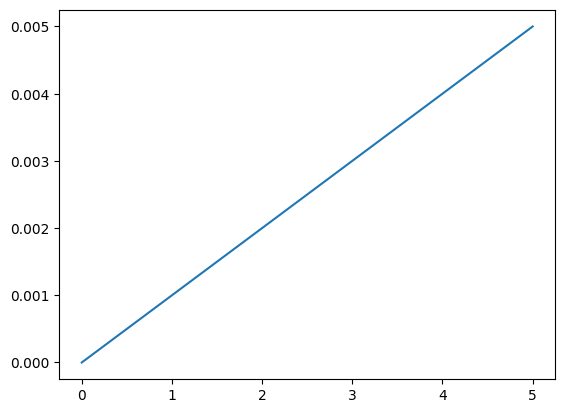

In [199]:
# Problem parameters
dt = 0.25                                     # Sampling period
T = 20                                        # steps to simulate
x = np.array([0, 0, 0., 1e-3, 0., 0.])                # Initial state
x_target =  np.array([150., 10., 0., 1., 0., 0.])              # Dummy for this exercise

bicycle_model = DynamicModel(bicycle_ode, dt)
bicycle_model.get_system(x, np.array([0, 0]))

x_history = []
u_history = []
for t in np.linspace(0, dt*T, T + 1):
    u, _, _, _ = mpc_control(bicycle_model, 20, x, x_target, dt)
    
    x_new = bicycle_model.next_x(x, u)

    x_history.append(x)
    u_history.append(u)

    x = x_new

print(u_history)
# print(x_history)

x_history = np.array(x_history)
u_history = np.array(u_history)

fig, ax = plt.subplots()
ax.plot(np.linspace(0, dt*T, T + 1), x_history[:, 0])
plt.show()